## Analysis of Sales data

### Dataset

The given dataset contains monthly total sales of a company for the period 2013-2016.

### Objectives

1. To analyse the sales data and understand the performance of the company.
2. Find patterns and construct a model to forecast future sales.


### Load sales data and create visualization

In [19]:
from time_series import TimeSeries

# Imports for data visualization
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld

register_matplotlib_converters()

In [38]:
a = pd.read_csv('../../data/MK_heartrate.csv')

# TimeSeries 패키지 사용을 위한 update_time => date로 변경
a.columns = ['source', 'tag_id', 'heart_beat_count', 'start_time', 'custom',
       'binning_data', 'date', 'create_time', 'max', 'min',
       'time_offset', 'deviceuuid', 'comment', 'pkg_name', 'end_time',
       'datauuid', 'heart_rate']

a_copy = a[['date', 'heart_rate']]

a_copy.to_csv('../../data/m_data.csv', index=False)

Sales Data
                                date    heart_rate
count                          65988  65988.000000
mean   2022-08-25 14:55:47.394071808     86.231163
min              2021-04-16 08:20:00     31.000000
25%              2022-03-03 19:34:00     73.000000
50%              2022-08-24 01:26:00     85.000000
75%              2023-02-22 16:37:15     98.000000
max              2023-09-22 05:12:00    213.000000
std                              NaN     16.482979
Head and Tail of the time series
date
2021-04-16 10:00:00     88
2021-04-16 15:40:00     86
2021-04-16 21:55:00     71
2021-04-17 02:31:00     79
2021-04-17 07:15:00    113
Name: heart_rate, dtype: int64
date
2023-09-12 00:32:00    104
2023-09-12 01:31:00    108
2023-09-12 02:20:00    103
2023-09-12 03:12:00    116
2023-09-12 04:12:00    114
Name: heart_rate, dtype: int64


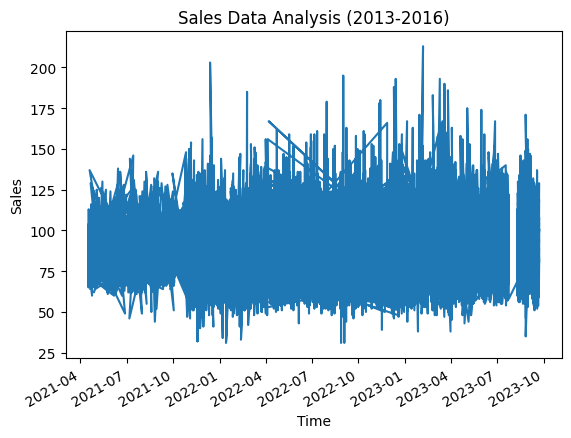

In [56]:
ts = TimeSeries('../../data/m_data.csv', train_size=0.8)

print("Sales Data")
print(ts.data.describe())

print("Head and Tail of the time series")
print(ts.data.head(5).iloc[:,1])
print(ts.data.tail(5).iloc[:,1])

# Plot of raw time series data
plt.plot(ts.data.index,ts.data.heart_rate)
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

In [41]:
print(ts.data.head(2))
print('==')
print(ts.set_scale)
print('==')
print(ts.train)

                                   date  heart_rate
date                                               
2021-04-16 10:00:00 2021-04-16 10:00:00          88
2021-04-16 15:40:00 2021-04-16 15:40:00          86
==
<bound method TimeSeries.set_scale of <time_series.TimeSeries object at 0x000001B90C12B110>>
==
date
2021-04-16 10:00:00     88
2021-04-16 15:40:00     86
2021-04-16 21:55:00     71
2021-04-17 02:31:00     79
2021-04-17 07:15:00    113
                      ... 
2023-03-26 08:51:00     88
2023-03-29 18:55:00     69
2023-03-31 12:29:00     83
2023-03-27 22:35:00     74
2023-03-29 19:15:00     69
Name: heart_rate, Length: 52790, dtype: int64


### Seasonal Decompose of the time series

Seasonal decompose is a method used to decompose the components of a time series into the following:
- Level - average value in the series.
- Trend - increasing or decreasing value in the series.
- Seasonality - repeating short-term cycle in the series.
- Noise - random variation in the series.

The analysis of the components individually provide better insights for model selection.

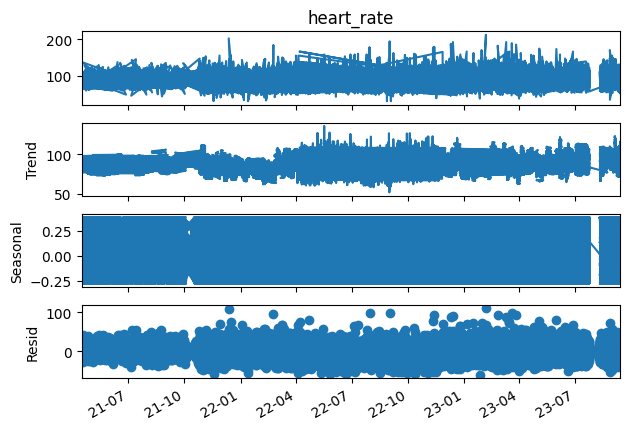

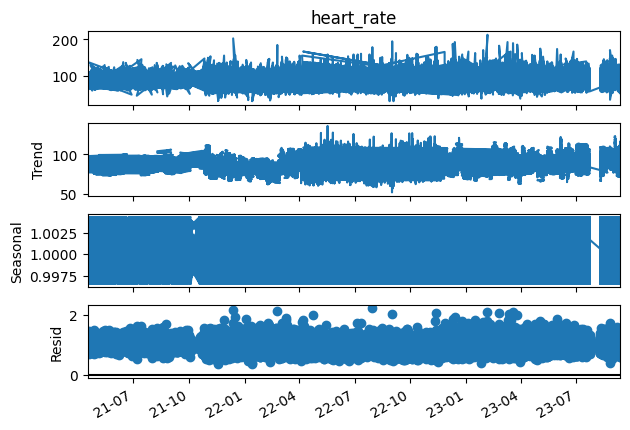

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(ts.data.iloc[:,1],period=12,model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(ts.data.iloc[:,1],period=12,model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()


### Observations from Seasonal Decompose

1. The time series seems to roughly have a constant seasonality but has an overall **increasing trend**.
2. A slightly decreasing trend is observed till 2014-07 after that an increasing trend is observed.

### Model Selection

From the above observations we can evidently conclude that **Holt-Winter additive model** would be an appropriate choice as there is a constant seasonality component along with an increasing trend.


c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\pandas\util\_decorators.py:210: FutureWarning: the 'damping_slope' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow

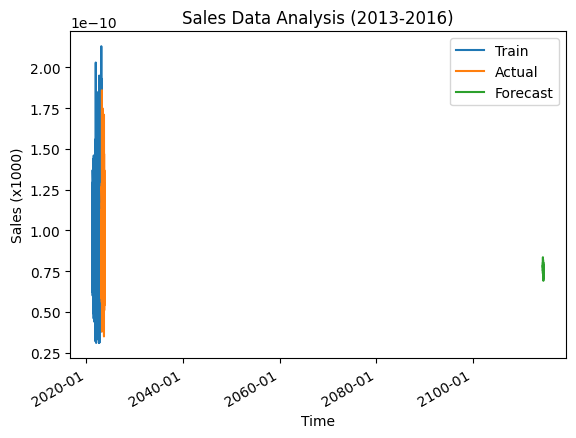

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Scaling down the data by a factor of 10, 각 값들을 10으로 나눠줌
ts.set_scale(10)

# Training the model
model = ExponentialSmoothing(ts.train,trend='additive',seasonal='additive',seasonal_periods=12).fit(damping_slope=1)
plt.plot(ts.train.index,ts.train,label="Train")
plt.plot(ts.test.index,ts.test,label="Actual")

plt.plot(model.forecast(48),label="Forecast")

plt.legend(['Train','Actual','Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales (x1000)")
plt.show()

c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\pandas\util\_decorators.py:210: FutureWarning: the 'damping_slope' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow

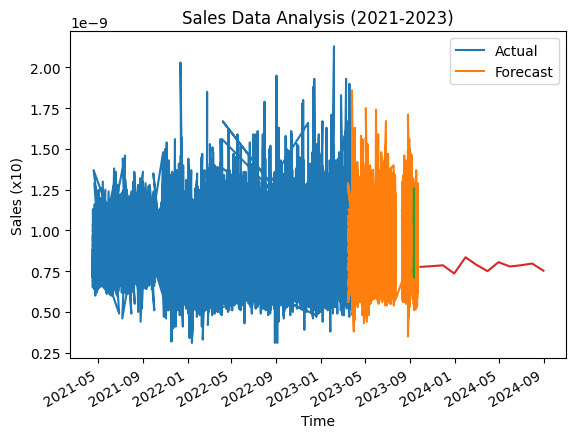

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Scaling down the data by a factor of 10, 각 값들을 10으로 나눠줌
ts.set_scale(10)

# Training the model
model = ExponentialSmoothing(ts.train,trend='additive',seasonal='additive',seasonal_periods=12).fit(damping_slope=1)
plt.plot(ts.train.index,ts.train,label="Train")
plt.plot(ts.test.index,ts.test,label="Actual")

forecast_steps = 12  # Adjust the number of forecast steps as needed

# Generate the forecasted time index
forecast_index = pd.date_range(start=ts.test.index[-1], periods=forecast_steps, freq='M')

# Plot the actual test data and forecasted values
plt.plot(ts.test.index[-forecast_steps:], ts.test.values[-forecast_steps:], label="Actual")
plt.plot(forecast_index, model.forecast(steps=forecast_steps), label="Forecast")

plt.legend(['Actual', 'Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2021-2023)")
plt.xlabel("Time")
plt.ylabel("Sales (x10)")
plt.show()

### Validation of the model
Let's do a brief comparison between the additive and the multiplicative models.

C:\Users\jun99\AppData\Local\Temp\ipykernel_30652\3322809250.py:4: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model_add = ExponentialSmoothing(ts.data.iloc[:,1],trend='additive',seasonal='additive',seasonal_periods=12,damped=True).fit(damping_slope=0.98)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\pandas\util\_decora

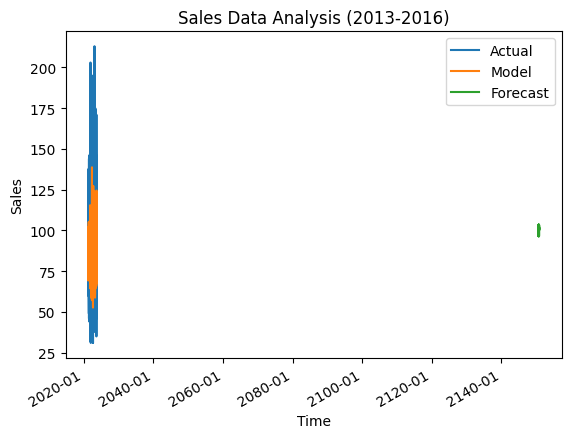

C:\Users\jun99\AppData\Local\Temp\ipykernel_30652\3322809250.py:22: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model_mul = ExponentialSmoothing(ts.data.iloc[:,1],trend='additive',seasonal='multiplicative',seasonal_periods=12,damped=True).fit()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model

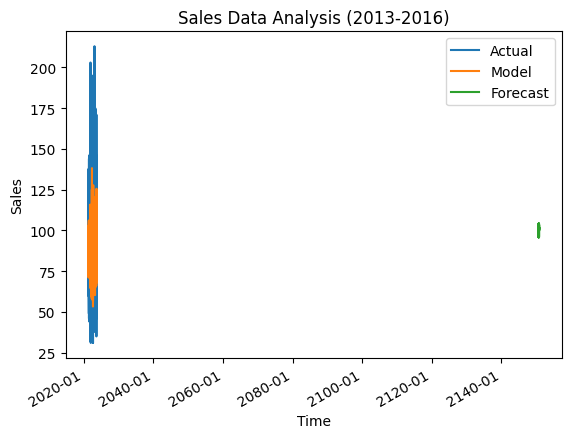

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Additive model
model_add = ExponentialSmoothing(ts.data.iloc[:,1],trend='additive',seasonal='additive',seasonal_periods=12,damped=True).fit(damping_slope=0.98)
prediction = model_add.predict(start=ts.data.iloc[:,1].index[0],end=ts.data.iloc[:,1].index[-1])

plt.plot(ts.data.iloc[:,1].index,ts.data.iloc[:,1],label="Train")
plt.plot(ts.data.iloc[:,1].index,prediction,label="Model")
plt.plot(model_add.forecast(60))

plt.legend(['Actual','Model','Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()


# Multiplicative model
model_mul = ExponentialSmoothing(ts.data.iloc[:,1],trend='additive',seasonal='multiplicative',seasonal_periods=12,damped=True).fit()
prediction = model_mul.predict(start=ts.data.iloc[:,1].index[0],end=ts.data.iloc[:,1].index[-1])

plt.plot(ts.data.iloc[:,1].index,ts.data.iloc[:,1],label="Train")
plt.plot(ts.data.iloc[:,1].index,prediction,label="Model")
plt.plot(model_mul.forecast(60))
plt.legend(['Actual','Model','Forecast'])
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

In [58]:
print(model_add.summary())
print(model_mul.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               heart_rate   No. Observations:                65988
Model:             ExponentialSmoothing   SSE                       13467829.605
Optimized:                         True   AIC                         350996.868
Trend:                         Additive   BIC                         351151.520
Seasonal:                      Additive   AICC                        350996.879
Seasonal Periods:                    12   Date:                 Mon, 25 Sep 2023
Box-Cox:                          False   Time:                         10:16:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1464286                alpha                 True
smoothing_trend          

### Conclusion of the analysis

From the model summary obtained it is clear that the sum of squared errors (SSE) for the additive model (5088109579.122) < the SSE for the multiplicative(5235252441.242) model.

Hence the initial assumption that seasonality is roughly constant and therefore choosing additive model was appropriate. 

Note:
The forecast made using multiplicative model seems to be unrealistic since the variance between the high and low on an average is **100000** which is somewhat unexpected in real world sales compared to **63000** incase of additive model.

